## 预处理

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# %config InlineBackend.figure_format = 'svg'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [36]:
%matplotlib notebook
%matplotlib notebook

In [3]:
nbaData = pd.read_csv('./data/nba/nba.csv')
nbaData.head()

,TRB,AST,STL,BLK,PTS,TOV,PF
0,252,138,46,30,724,74,225
1,4,0,1,1,10,2,5
2,627,160,67,48,1393,104,231
3,5,2,1,1,4,0,9
4,82,16,11,5,105,22,68


In [4]:
lionData = pd.read_csv('./data/lion-reference.csv',header=None)
lionData.head()

,0,1,2
0,-0.040110,0.224513,-0.064178
1,-0.035460,0.234662,-0.091287
2,-0.028643,0.226311,-0.091565
3,-0.036914,0.239158,-0.110594
4,-0.029853,0.231213,-0.112309


In [5]:
cactusData = pd.read_csv('./data/Cactus.txt',header=None,sep='\t')
cactusData.head()

,0,1,2
0,0.520412,0.455527,0.476147
1,0.534901,0.451687,0.492928
2,0.538826,0.464909,0.494495
3,0.562822,0.497936,0.503670
4,0.553440,0.479522,0.503670


寻找一种好的降维方法，正交化？

In [6]:
data = cactusData

In [7]:
N = len(data)
print("N :",N)

N : 3280


In [8]:
# a = preprocessing.normalize(data.values)
a = data.values

**设定最近邻的参数K**

In [9]:
k = 6

In [10]:
neigh = NearestNeighbors(n_neighbors=k+1) # 因为之后提取最近点时会包括点自身
neigh.fit(a)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=7, p=2, radius=1.0)

In [11]:
disMat,nodeMat = neigh.kneighbors(a)

In [12]:
print(disMat.shape)
print(disMat)

(3280, 7)
[[0.         0.0056119  0.009174   ... 0.0126342  0.018349   0.02066633]
 [0.         0.01148081 0.01148321 ... 0.01529815 0.01575098 0.01748192]
 [0.         0.009174   0.009175   ... 0.01585885 0.018348   0.018349  ]
 ...
 [0.         0.007339   0.00734    ... 0.01148134 0.0136264  0.01362652]
 [0.         0.007339   0.00734    ... 0.01148134 0.01362652 0.01362652]
 [0.         0.007339   0.00734    ... 0.01148165 0.01362652 0.01362678]]


In [13]:
print(nodeMat.shape)
print(nodeMat)

(3280, 7)
[[   0 1417 1418 ... 1411 1412 2565]
 [   1 2566    5 ... 2568 2476   13]
 [   2 2476   13 ...    5 2565   12]
 ...
 [3277 2547 3094 ... 3209 2561 2286]
 [3278 3248 3078 ... 3276 2149 2152]
 [3279 2149 3079 ... 1222 3248  747]]


<IPython.core.display.Javascript object>


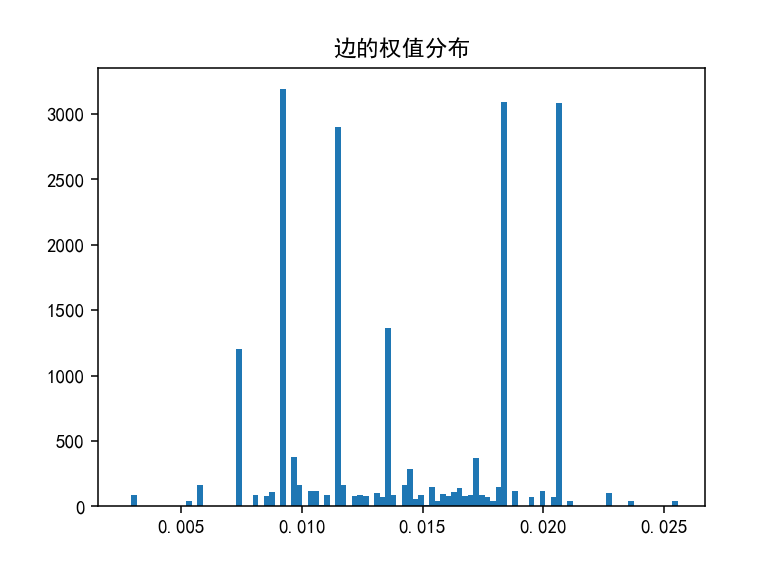

In [14]:
a = disMat.flatten()
plt.title('边的权值分布');
plt.hist(a[a.nonzero()],bins=100);

## 建图

In [20]:
G = nx.Graph()

In [21]:
G.add_nodes_from(range(nodeMat.shape[0]))

In [22]:
edges = []
for i,(neighbors,distances) in enumerate(zip(nodeMat,disMat)):
    edges +=[(i, neighbors[j], distances[j]) for j in range(k+1) if neighbors[j]!=i]
print(edges[:5])

[(0, 1417, 0.005611900569325927), (0, 1418, 0.009174000000000071), (0, 2566, 0.01228641798898286), (0, 1411, 0.012634196848236943), (0, 1412, 0.01834900000000006)]


In [23]:
G.add_weighted_edges_from(edges)

In [24]:
print('node size',len(G.nodes))

node size 3280


### 3D

<IPython.core.display.Javascript object>


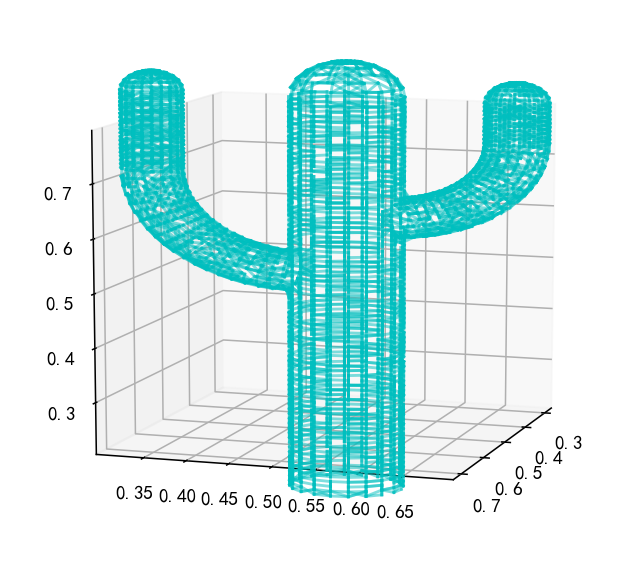

(0.4273395, 0.5726605, 0.2214679, 0.7785321)

In [25]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.')
for a,b,_ in edges:
    if np.random.rand()>0.5:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='c')
ax.axis('equal')

### plain

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


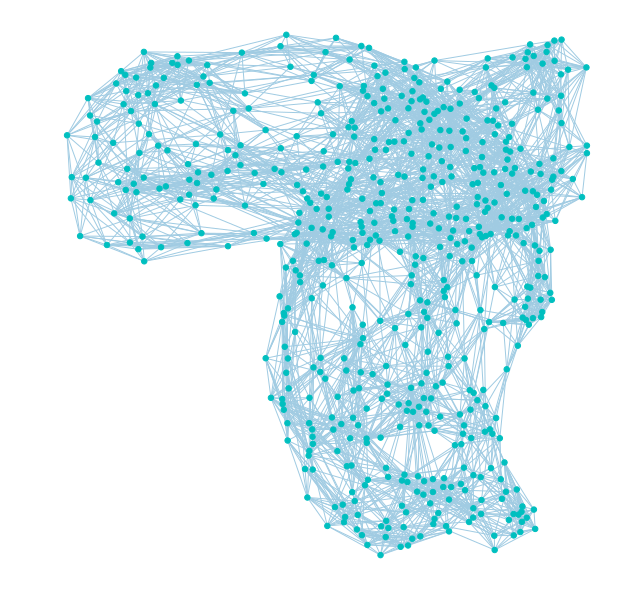

In [19]:
# plt.figure(figsize=(8,8))
# pos = nx.spring_layout(G)
# nx.draw(G,node_shape='o',pos=pos,node_size=30,node_color='c',edge_color='#A0CBE2')

## 投票

https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html

In [26]:
import numpy as np
from collections import defaultdict

In [27]:
dis = dict(nx.all_pairs_bellman_ford_path_length(G))

In [28]:
with open('disMat','w') as f:
    f.write(str(N)+'\n')
    for i in range(N):
        for j in range(N):
            f.write(str(dis[i][j])+' ')

In [42]:
del dis

仅作为参考，现在使用c实现这一部分
```
nodeIdx = list(range(N))
samples = 50000
subSamples = 10000
th = 0.01
conditon = lambda a,b,c,d:abs(dis[a][b]-dis[c][d])<th and abs(dis[a][d]-dis[b][c])<th

votes = defaultdict(int)

for i in range(samples):
    a,b,c,d=np.random.choice(nodeIdx,4)
    if conditon(a,b,c,d):
        for j in range(subSamples):
            e,f = np.random.choice(nodeIdx,2)
            if conditon(a,b,e,f) and conditon(c,d,e,f):
                if b>a:
                    a,b=b,a
                if d>c:
                    c,d=d,c
                votes[(a,b)]+=1
                votes[(c,d)]+=1
```

In [29]:
a = np.loadtxt('./out.txt')
votes = defaultdict(int)
for i,j in zip(a.nonzero()[0],a.nonzero()[1]):
    v = a[i,j]
    assert v>0
    if i==j:continue
    if i<j:
        i,j=j,i
    votes[(i,j)] += v

<IPython.core.display.Javascript object>


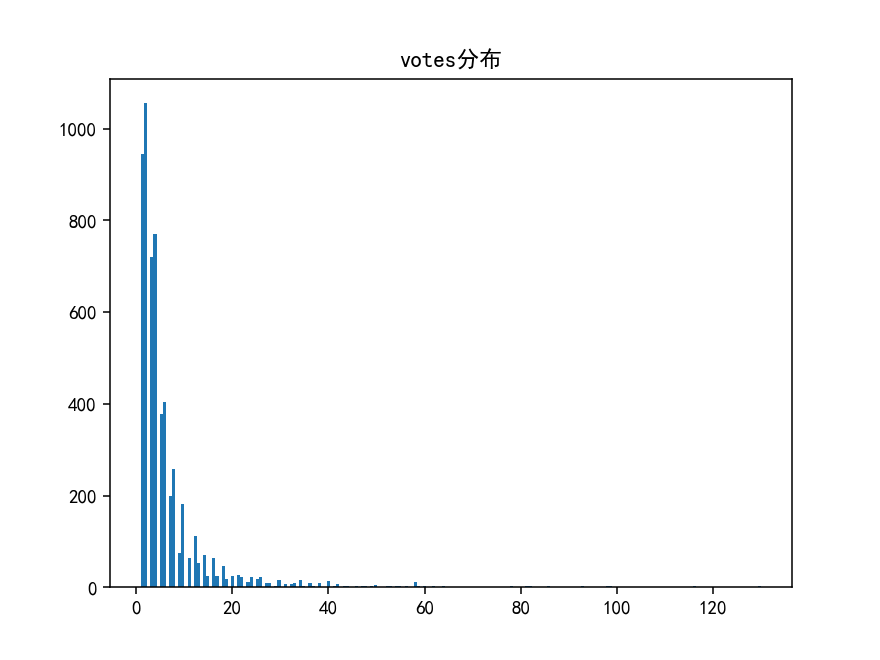

(array([ 945., 1055.,    0.,  721.,  771.,    0.,  378.,  404.,    0.,
         200.,  258.,    0.,   74.,  182.,    0.,   63.,    0.,  113.,
          54.,    0.,   70.,   25.,    0.,   65.,   24.,    0.,   46.,
          18.,    0.,   24.,    0.,   26.,   22.,    0.,   12.,   22.,
           0.,   18.,   22.,    0.,   10.,   10.,    0.,    4.,   16.,
           0.,    8.,    0.,    8.,   10.,    0.,   16.,    4.,    0.,
          10.,    2.,    0.,   10.,    0.,    0.,   14.,    0.,    4.,
           8.,    0.,    2.,    2.,    0.,    0.,    4.,    0.,    2.,
           4.,    0.,    2.,    6.,    0.,    0.,    0.,    4.,    2.,
           0.,    4.,    2.,    0.,    2.,    0.,    0.,   12.,    2.,
           0.,    4.,    0.,    0.,    4.,    0.,    0.,    4.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    4.,    0.,    0.,    0.,    0.,    2.,    2.,
      

In [41]:
# plt.xlim((0,50))
plt.title('votes分布')
plt.hist(votes.values(),bins=200)

In [43]:
path = dict(nx.all_pairs_bellman_ford_path(G))

**设定votes的阈值**

In [44]:
th_votes = 10

In [61]:
nodeSet = set()
for a,b in votes.keys():
    pi = path[a][b]
    if votes[(a,b)]>th_votes:
        nodeSet.add(pi[len(pi)//2])
print(nodeSet)

{2048, 2, 3, 7, 8, 2057, 2058, 11, 13, 2063, 20, 2074, 2075, 2077, 31, 2082, 35, 36, 2085, 2086, 46, 2096, 2100, 55, 62, 67, 2117, 71, 72, 74, 2123, 2126, 78, 2128, 2129, 2130, 83, 82, 85, 86, 2138, 2139, 91, 93, 2141, 2150, 104, 106, 108, 109, 2157, 113, 2162, 116, 118, 120, 122, 2172, 2174, 2176, 2180, 2182, 2185, 138, 2190, 143, 145, 2198, 2200, 2202, 2203, 2209, 2211, 2212, 2215, 167, 2217, 2218, 2224, 177, 2227, 2228, 186, 2235, 188, 2238, 190, 2240, 2241, 197, 198, 201, 2250, 2254, 2255, 2257, 2258, 2259, 2263, 2271, 2274, 2275, 229, 2277, 235, 237, 239, 247, 251, 252, 2301, 254, 258, 260, 2310, 265, 266, 267, 269, 2318, 270, 2320, 2321, 277, 278, 2328, 2329, 281, 280, 2335, 2340, 2344, 2351, 306, 2357, 2358, 314, 2363, 2366, 319, 2369, 325, 329, 2379, 332, 334, 2387, 341, 2390, 345, 346, 2403, 357, 361, 363, 2412, 2417, 371, 377, 2425, 2430, 383, 390, 2442, 2450, 405, 2458, 415, 420, 422, 423, 428, 2480, 2482, 435, 2484, 436, 438, 2489, 2492, 2494, 448, 2498, 2499, 452, 2501, 25

In [ ]:
# del path

## 构建子图

### 3D

<IPython.core.display.Javascript object>


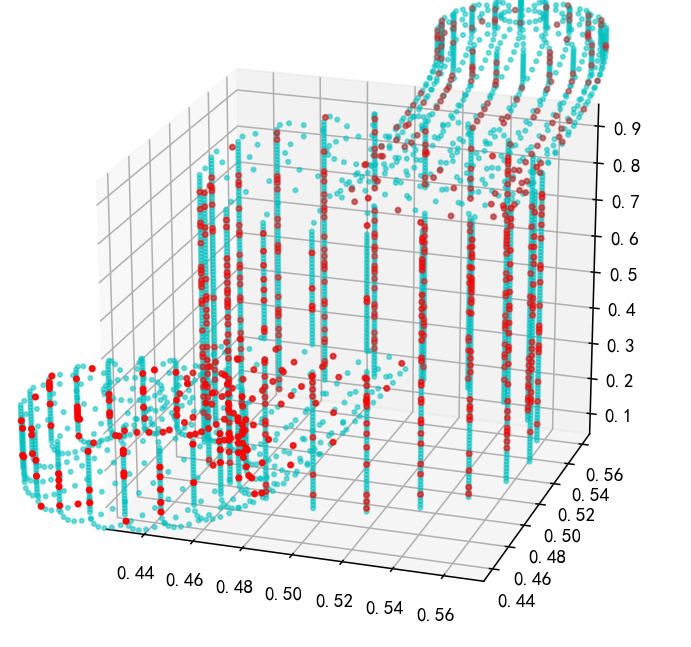

(0.4273395, 0.5726605, 0.2214679, 0.7785321)

In [56]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
ax.scatter3D(*data.to_numpy().T,marker='.',color='c',alpha=0.5)
ax.scatter3D(*data.iloc[[*nodeSet]].to_numpy().T,marker='.',s=30,color='r')
ax.axis('equal')

In [66]:
G2 = G.subgraph(nodeSet)
edgeSet = G2.edges() # not set actually

<IPython.core.display.Javascript object>


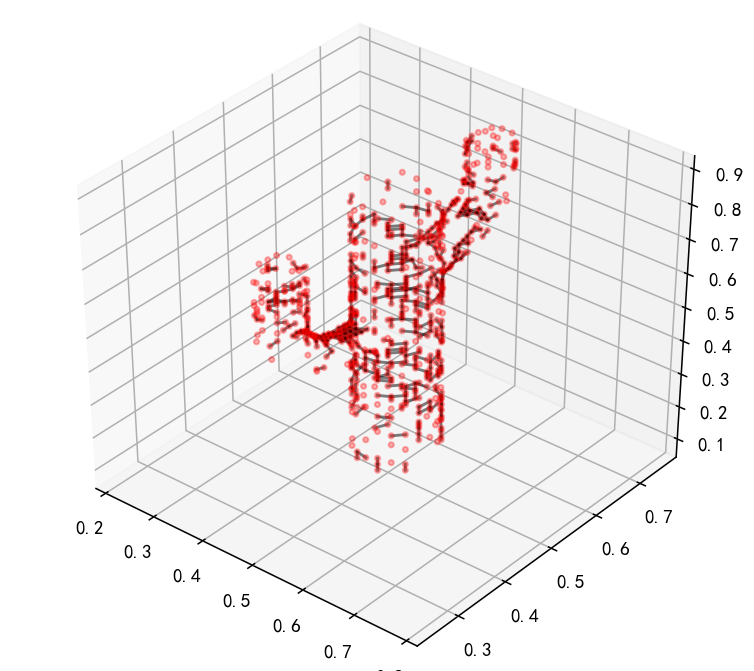

(0.4273395, 0.5726605, 0.22155769999999997, 0.7766462999999999)

In [71]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.',color='c',alpha=0.5)
ax.scatter3D(*data.iloc[[*nodeSet]].to_numpy().T,marker='.',s=30,color='r',alpha=0.3)
for a,b in edgeSet:
    if np.random.rand()>-1:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='k')
ax.axis('equal')

### plain

**在原图位置上展示**

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


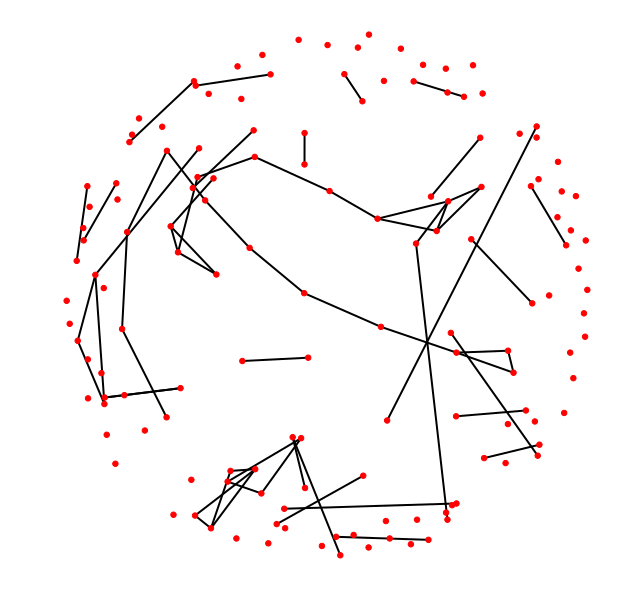

In [141]:
G2 = G.subgraph(nodeSet)
plt.figure(figsize=(8,8))
nx.draw(G2,pos=pos,node_shape='o',node_size=30,width=2)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


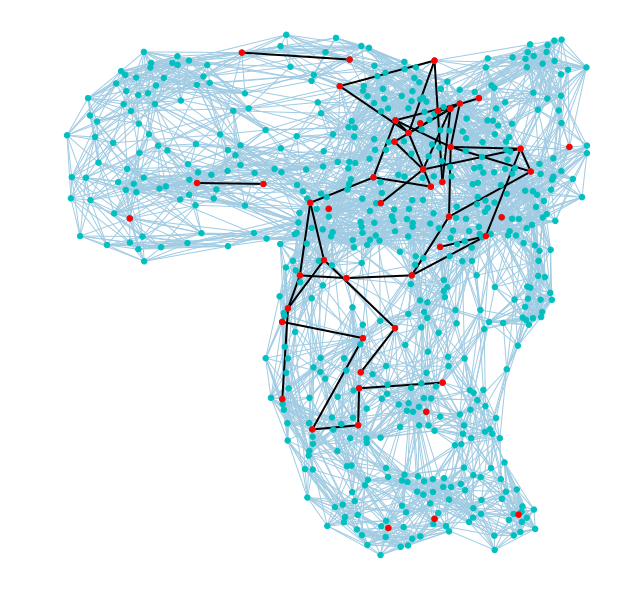

In [88]:
plt.figure(figsize=(8,8))
nx.draw(G,node_shape='o',node_size=30,pos=pos, node_color='c' ,edge_color='#A0CBE2')
nx.draw(G2,node_shape='o',pos=pos, node_size=30,width=2)
# nx.drawing.nx_pylab.draw_networkx_nodes(G,pos,nodeSet,node_size=50)
# nx.drawing.nx_pylab.draw_networkx_edges(G,pos,votes.keys(),width=1.5,edge_color='y')

**使用图布局算法(Fruchterman-Reingold force-directed algorithm)**

事实上默认就是用了图布局算法的

In [ ]:
plt.figure(figsize=(8,8))
nx.draw(G2,node_shape='o',node_size=30,width=2)